In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import squidpy as sq
import scanpy as sc
import pandas as pd
import os
from PIL import Image
import imagecodecs
import tifffile as tff
from pyometiff import OMETIFFReader
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

import pickle
import json
import umap
import anndata as ad

# Defining functions

In [ ]:
## Read nucleus/cell boundary .csv files + cell summary .csv

def read_boundary_files(data_dir,sample_dir):
    nucleus_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'nucleus_boundaries.csv.gz'))
    cell_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'cell_boundaries.csv.gz'))
    #transcripts=pd.read_csv(os.path.join(data_dir,sample_dir,'transcripts.csv.gz'))    
    #cells=pd.read_csv(os.path.join(data_dir,sample_dir,'cells.csv.gz'))

    return nucleus_bound,cell_bound


### =================================================================
## Read __morphology_focus.ome.tiff__ DAPI-fluorescence picture of slide
def read_ome_tiff(slide_type,data_dir,sample_dir):
    if slide_type=='focus':
        fn=os.path.join(data_dir,sample_dir,'morphology_focus.ome.tif')

    if slide_type=='mip':    
        fn=os.path.join(data_dir,sample_dir,'morphology_mip.ome.tif')

    if slide_type=='z_stack': 
        fn=os.path.join(data_dir,sample_dir,'morphology.ome.tif')
        
    reader = OMETIFFReader(fpath=fn)
    img_array,metadata,xml_metadata=reader.read()

    return img_array,metadata,xml_metadata



### =================================================================

## Create dataframe of mask polygon coordinates from json outputs, that Baysor created
def create_cell_bound_df(polygon_fn,seg):

    ## The cell names in segmentation.csv have a prefix in front of the cell name (i.e.'CRe50034e63-1')
    #  Extract that prefix and add it to the cell names coming from the json file to make them uniform
    prefix=seg.loc[~seg['cell'].isna(),'cell'].str.split('-',expand=True)[0].unique()

    if len(prefix)!=1:
        raise ValueError('Multiple prefixes in the segmentation.csv cell column => check the length of prefix variable in create_polygon_df() function!')

    prefix=prefix[0]
    
    import json
    # Opening JSON file
    f=open(polygon_fn)
    polygon=json.load(f)
    
    ## Init list to collect cell dfs with coordinates
    df_list=[]
    for n in range(len(polygon['geometries'])):
        ## Extract polygon coordinates
        coord=np.squeeze(np.array(polygon['geometries'][n]['coordinates']))
        
        ## Add only cells with non-empty masks
        if (coord.shape[0])>0:

            ## Extract cell name
            cell_name=polygon['geometries'][n]['cell']
            cell_name_arr=np.array([cell_name,]*int(coord.shape[0]))

            ## Stack coordinates and cell_name and create dataframe
            coord_with_name=np.hstack((coord,cell_name_arr.reshape(-1, 1)))
            colnames=['vertex_x_pixel','vertex_y_pixel','cell_id']
            df=pd.DataFrame(data=coord_with_name,columns=colnames)
        
            ## If cell name doesn't start with prefix (most of the time it doesn't, sometimes it does as it was saved with the prefix in the json file),
            #  add prefix

            #if not str(cell_name).startswith(prefix):
            df['cell_id']=prefix + '-' + df['cell_id'].astype(int).astype(str)
            df_list.append(df)

    ## Concatenate all cell dfs into one
    df=pd.concat(df_list)    

    return df    


### =================================================================

## Calculate nucleus pixel metric: median/mean/max/mode of nucleus pixels
def return_polygon_pixel_metric(x,img_array,metric):
    from matplotlib import path
    import statistics as st
    import warnings
    warnings.filterwarnings("ignore")
       
    ## Extract the vertex points of nucleus polygon + boundaries of 
    polygon_vert=list(zip(x['vertex_x_pixel'],x['vertex_y_pixel']))

    ## Extract rectangle around nucleus -> get coordinates of nucleus polygon and create rectangle
    x_min=int(x['vertex_x_pixel'].min())
    x_max=int(x['vertex_x_pixel'].max())

    y_min=int(x['vertex_y_pixel'].min())
    y_max=int(x['vertex_y_pixel'].max())


    ## Create rectangle around nucleus
    nx,ny=x_max-x_min+1,y_max-y_min+1
    x_,y_=np.meshgrid(np.arange(nx), np.arange(ny))
    x__,y__=x_.flatten()+x_min, y_.flatten()+y_min

    points = np.vstack((x__,y__)).T

    ## Check if created rectangle's pixels are inside/outside of polygon -> 
    #  mask_: boolean mask; False: pixel outside of nucl. polygon; True: pixel inside of nucl. polygon)
    p=path.Path(polygon_vert)
    mask=p.contains_points(points)
    mask_=mask.reshape(ny,nx)



    ## Extract the pixel numbers of the pixels from inside the polygon 
    #  Subset original image to rectangle around nucleus (saves memory)

    ## Some polygons output by Baysor are outside of the image -> their coordinates are larger than the img_array's shape
    #  => In this case just only take part of the polygons that lies on the image = resize mask_ to fit on img_array
    y_max_coor=min(img_array.shape[0],y_min+ny)
    x_max_coor=min(img_array.shape[1],x_min+nx)
    sub_img_array=img_array[y_min:y_max_coor,x_min:x_max_coor]
    mask_=mask_[0:y_max_coor-y_min,0:x_max_coor-x_min]

    ## Calculate metric of nucleus pixels (rectangle masked with boolean mask)

    def return_indentity(x):
        return x
    
    metric_dict={'median':np.median,'mean':np.mean,'max':np.max,'mode':st.mode,'raw_vals':return_indentity}
    metric_func=metric_dict[metric]


    ## Check if there are at least 3 unique polygon vertices (for some points baysor outputs only 1 unique x-y pair)
    try:
        nucleus_polygon_metric=metric_func(sub_img_array[mask_].flatten())
    except ValueError:
         nucleus_polygon_metric=np.nan

    '''
    ## Plotting functions to showcase the pixels of the polygon for one nucleus
    #  For this, run the following code outside of ths function:

    #  cell_id='aaaejiml-1'
    #  nucleus_bound[nucleus_bound['cell_id']==cell_id].groupby('cell_id').apply(return_polygon_pixels,img_array=img_array)

    #print('mask_',mask_)
    
    ## Plot the nuclues boolean mask 
    fig,ax=plt.subplots(1,3,figsize=(8,5))
    ax[0].imshow(mask_,origin='upper')

    ## Plot the polygon with GeoPandas dataframe for given cell
    #nucleus_polygons.loc[nucleus_polygons.index.isin(['aaaejiml-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    #nucleus_polygons.loc[nucleus_polygons.index.isin(['aaakgmde-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    #ax[1].invert_yaxis()

    ## Show raw nucleus data taken from oiriginal image
    #  Subset original slide image to a rectangle around the nucleus 
    sub_img_array=img_array[y_min:y_min+ny,x_min:x_min+nx]
    img=ax[1].imshow(points,origin='upper')

    ## Show nucleus masked with polygon + DAPI intensities inside of polygon
    #sub_img_array[~mask_]=0
    img2=ax[2].imshow(sub_img_array,origin='upper')
    #plt.colorbar(img2, ax=ax[2])
    plt.show()
    
    '''
    
    return nucleus_polygon_metric



# Load files

In [6]:
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"#processed_data/cell_segmentation"

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()

segmend_dict={'no_segmentation':{},
             '10x':{'expansion_sizes':[0]},
             'cellpose':{'expansion_sizes':[4,6,10],
                         'modes':['cyto','nucleus']}
             }


for panel in panel_dir[1:2]:
    panel_dir=os.path.join(data_dir,panel)
 
    ## Loop over all samples in a batch
    for sample_name in os.listdir(panel_dir)[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)

        if os.path.isdir(sample_dir): #and 'P1_D' in sample_dir:
            sample_dict={}
            
            ## Extract Panel_Sample_name as string
            panel_sample_name='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])
            print(panel_sample_name)

            ## Load DAPI fluorescent-stained slide image
            # Select one slide_type ('mip'/'focus'/z_stack') file to load and 
            slide_type='mip'
            img_array,metadata,xml_metadata=read_ome_tiff(slide_type,data_dir,sample_dir)
            print('Slide loaded')

            ## Create baysor output folder path
            baysor_out_fold=os.path.join(data_dir,'processed_data/baysor_output',panel_sample_name)

            ## Get only name of folders to loop over in baysor_output folder (filter for segmentation methods as well)
            bays_model_dirlist=[filename for filename in os.listdir(baysor_out_fold) if os.path.isdir(os.path.join(baysor_out_fold,filename))]
            bays_model_dirlist=[filename for filename in bays_model_dirlist if any(x in filename for x in ['no_segmentation','10x'])]
            
            
            ### Loop over baysor segmentation models and extract cell mask polygon metrics
            for bays_model_name in bays_model_dirlist[:]:
                print(bays_model_name)

                ## Read in segmmentation results + cell statistics output by Baysor (cells stats, area of cells)
                seg_fn=os.path.join(baysor_out_fold,bays_model_name,'segmentation.csv')
                seg=pd.read_csv(seg_fn)

                
                seg_stats_fn=os.path.join(baysor_out_fold,bays_model_name,'segmentation_cell_stats.csv')
                seg_stats=pd.read_csv(seg_stats_fn)

                polygon_fn=os.path.join(baysor_out_fold,bays_model_name,'segmentation_polygons.json')
                cell_bound=create_cell_bound_df(polygon_fn,seg)


                ## Extract pixels of cell mask polygons (identified by Baysor model) and return a dataframe with some metrics of these pixel 
                #  intensities
                metric_df_list=[]
                metric_list=['median','mean','max','mode','raw_vals']
                for metric in metric_list:
                    temp_df=cell_bound.groupby('cell_id').apply(return_polygon_pixel_metric,img_array=img_array,metric=metric)
                    metric_df_list.append(temp_df)                
                #del img_array               
                nucleus_polygon_pixel_metrics=pd.concat(metric_df_list,axis=1)
                nucleus_polygon_pixel_metrics.columns=metric_list
                print('Nuclear polygon metrics calculated')

                
                ## Save the processed data as a dictionary
                sample_dict['seg_stats']=seg_stats
                sample_dict['cell_bound']=cell_bound
                sample_dict['nucleus_polygon_pixel_metrics']=nucleus_polygon_pixel_metrics
                
                proc_dir=os.path.join(data_dir,'processed_data/true_cell_filtering/baysor',panel_sample_name,bays_model_name)
                
                if not os.path.isdir(proc_dir):
                    os.makedirs(proc_dir)
                    print(f'Created directory: {proc_dir}')

                fpath=os.path.join(proc_dir,panel_sample_name+'.pickle')
                pickle.dump(sample_dict, open(fpath, "wb"))
                print(f'{panel_sample_name}-{bays_model_name} saved as pickle\n')
                
            

Panel2_P4_H


Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Slide loaded
assignments_baysor-no_segmentation
Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel2_P4_H/assignments_baysor-no_segmentation
Panel2_P4_H-assignments_baysor-no_segmentation saved as pickle

assignments_10x_baysor-10x_0
Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel2_P4_H/assignments_10x_baysor-10x_0
Panel2_P4_H-assignments_10x_baysor-10x_0 saved as pickle

Panel2_P2_D
Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Slide loaded
assignments_baysor-no_segmentation
Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/proce

In [4]:

def generate_anndata(panel_sample_name,bays_model_name,seg,seg_stats,nucleus_polygon_pixel_metrics,confidence_thr=0.8,
                     assignment_confidence_thr=0.5,plot_confidence_distr=False):

    ### Based on the description if the output columns found at https://github.com/kharchenkolab/Baysor)
    '''
    confidence: probability of a molecule to be real (i.e. not noise)
    cell: id of the assigned cell. Value "" corresponds to noise.
    cluster: id of the molecule cluster
    assignment_confidence: confidence that the molecule is assigned to a correct cell
    is_noise: shows whether molecule was assigned to noise (it equals true if and only if cell == "")
    ncv_color: RGB code of the neighborhood composition coloring
    '''
    #### FILTER TRANSCRCIPTS WITH LOW CONFIDENCE
    ## Filter result of baysor segmentation based on the threshold values 
    seg_true=seg[(~seg['cell'].isna())&\
                (seg['confidence']>confidence_thr)&\
                (seg['assignment_confidence']>assignment_confidence_thr)] 


    #### EXTRACT COUNT MATRIX OF TRANSCRIPTS
    ## Extract the transcript counts for each gene for each cell 
    a=seg_true.groupby('cell').apply(lambda x: (x['gene'].value_counts(dropna=False)))

    l=[]
    for cell_series in a.index.get_level_values('cell').unique():
        # Rename 'count' column to gene => This will be the index column with the gene names in the final concatenated dataframe
        c=a[cell_series]
        c.rename(cell_series, inplace=True)
        l.append(c)

    ## Concatenate the list of pd.series of gene counts for each cell
    count_df=pd.concat(l,axis=1,join='outer').T.fillna(0)
    count_df=count_df.rename(index={'gene': 'cell_id'})


    #### CREATE ADATA.OBS & ADATA.VAR DATAFRAME
    ## Set cell_id as index for seg_stats df to make it uniform with other df-s
    seg_stats=seg_stats.rename(columns={'cell': 'cell_id'})
    seg_stats=seg_stats.set_index('cell_id')

    ## Extract list of True cell names => intersection of filtered cells (count_df) and 
    #  cells with non-zero polygon mask (nucleus_polygon_pixel_metrics contains only cells with non-zero masks see function 
    #  "create_cell_bound_df()" which created cell_bound_df)
    true_cells_ind=list(set(count_df.index)&set(nucleus_polygon_pixel_metrics.index))

    ## Add metrics of cell mask DAPI intensities and subset only to true cells 
    mask_stat_cols=['mean','median','max','mode']
    seg_stats_=seg_stats.copy()
    seg_stats_.loc[true_cells_ind,mask_stat_cols]=nucleus_polygon_pixel_metrics.loc[true_cells_ind,mask_stat_cols].values
    seg_stats_=seg_stats_.rename(columns={'mean':'mean_DAPI_intensity','median':'median_DAPI_intensity','max':'max_DAPI_intensity','mode':'mode_DAPI_intensity'})
    
    ## Calculate the area of the cell masks 
    #  => segmentation_stats.csv 'area' column: area of the convex hull around the cell molecules, not the cell masks' area
    cell_mask_areas=nucleus_polygon_pixel_metrics['raw_vals'].apply(lambda x: x.shape[0])
    seg_stats_['cell_mask_area']=cell_mask_areas[true_cells_ind]

   
    cell_mask_areas
    ## Create adata.obs dataframe
    obs=seg_stats_.loc[true_cells_ind,:].copy()

    # Create adata.var dataframe
    var=pd.DataFrame(index=count_df.columns)


    #### CREATE ANNDATA OBJECT
    # Extract the count matrix of true cells from count_df
    from scipy import sparse
    X=count_df.loc[true_cells_ind,:].values
    adata=ad.AnnData(X, obs=obs, var=var, dtype='int64')
    adata.X=sparse.csr_matrix(adata.X)
    adata.layers['raw_counts']=adata.X.copy()


    #### ADD ADDITIONAL METADATA & CALCULATE BASIC STATISTICS
    ## Add noise information
    pct_noise=sum(seg['cell'].isna())/len(seg)
    adata.uns['pct_noise']=pct_noise

    ## Add raw DAPI intensity values of cell masks
    adata.uns['raw_DAPI_intensities']=nucleus_polygon_pixel_metrics['raw_vals']

    #Calculate some basic statistics   
    adata.obs['n_counts']=adata.X.sum(axis=1).A1
    adata.obs['n_genes']=(adata.X>0).sum(axis=1).A1
    adata.var['n_counts']=adata.X.sum(axis=0).A1
    adata.var['n_cells']=(adata.X>0).sum(axis=0).A1

    ## Print basic information about dataset
    print(f"Dataset: {panel_sample_name} - {bays_model_name}")
    print(f'Number of raw transcripts: {len(seg)}')
    print(f"Number of transcripts deemed as noise: {sum(seg['cell'].isna())} - {round(pct_noise*100,2)}%")
    print(f'Number of transcripts kept after filtering: {len(seg_true)} - {round(100*len(seg_true)/len(seg),2)}%')

    if plot_confidence_distr==True:
        fig_suptitle=' - '.join([panel_sample_name,bays_model_name])

        fig,ax=plt.subplots(1,2,figsize=(10,4.5))
        sns.histplot()
        sns.histplot(seg['confidence'],bins=100,ax=ax[0])
        sns.histplot(seg['assignment_confidence'],bins=100,ax=ax[1])
        ax[0].axvline(confidence_thr,color='red')
        ax[1].axvline(assignment_confidence_thr,color='red')

        fig.suptitle(fig_suptitle,fontweight='bold',y=1)
        plt.tight_layout()


    return adata




Dataset: Panel1_P1_H - assignments_baysor-no_segmentation
Number of raw transcripts: 505947
Number of transcripts deemed as noise: 24640 - 4.87%
Number of transcripts kept after filtering: 413685 - 81.76%


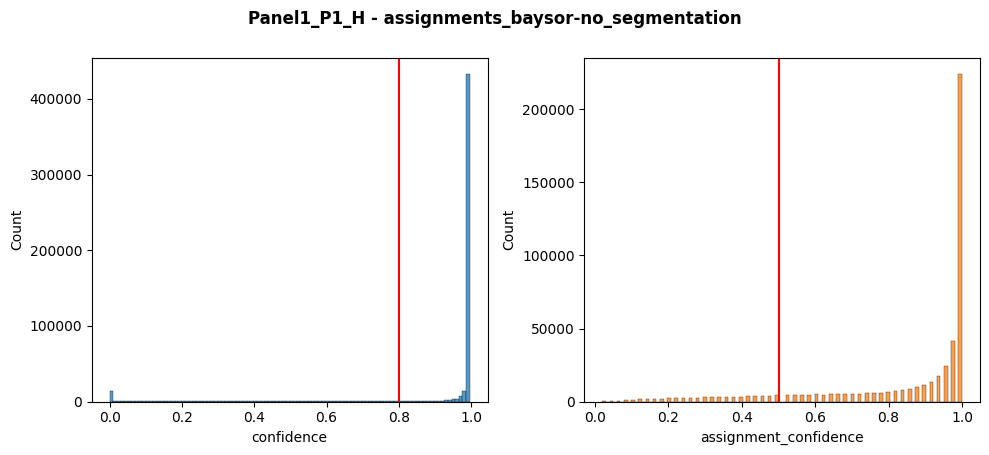

In [5]:
adata=generate_anndata(panel_sample_name,bays_model_name,seg,seg_stats,nucleus_polygon_pixel_metrics,confidence_thr=0.8,
                     assignment_confidence_thr=0.5,plot_confidence_distr=True)

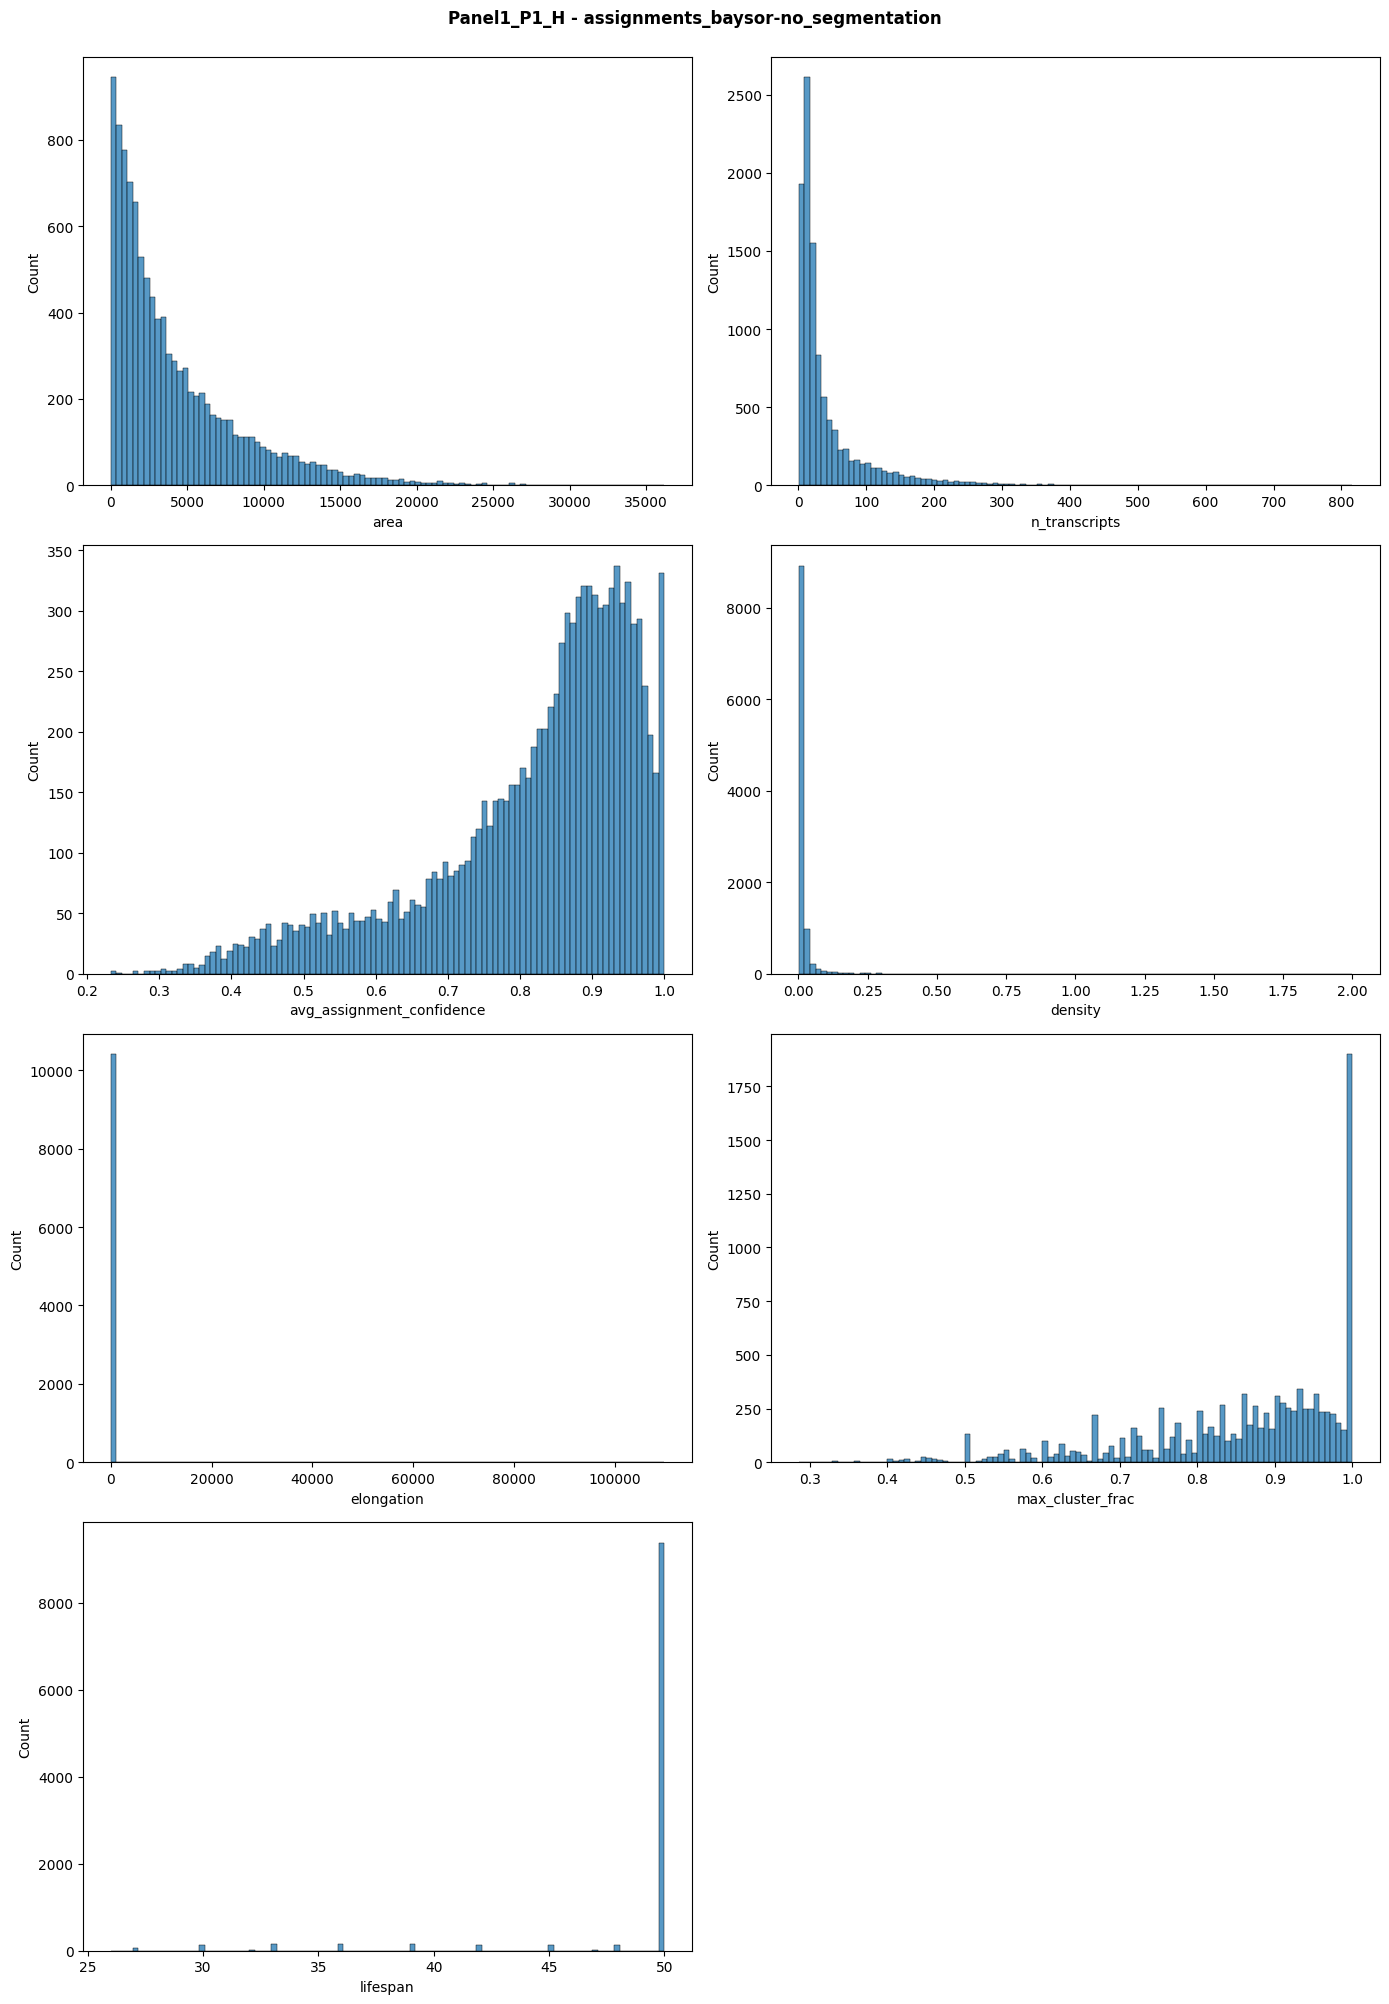

In [6]:
'''
area: area of the convex hull around the cell molecules

avg_confidence: average confidence of the cell molecules

density: cell area divided by the number of molecules in a cell

elongation: ratio of the two eigenvalues of the cell covariance matrix

n_transcripts: number of molecules per cell

avg_assignment_confidence: average assignment confidence per cell. Cells with low avg_assignment_confidence have a
                           much higher chance of being an artifact.

max_cluster_frac (only if n-clusters > 1): fraction of the molecules coming from the most popular cluster. 
                                           Cells with low max_cluster_frac are often doublets.

lifespan: number of iterations the given component exists. The maximal lifespan is clipped proportionally to the 
          total number of iterations. Components with a short lifespan likely correspond to noise.
'''
import math


qc_cols=['area','n_transcripts','avg_assignment_confidence','density','elongation','max_cluster_frac','lifespan']
ncols=2
nrows=math.ceil(len(qc_cols)/ncols)
fig=plt.figure(figsize=(ncols*7,nrows*5))

fig_suptitle=' - '.join([panel_sample_name,bays_model_name])
fig.suptitle(fig_suptitle,fontweight='bold',y=1)

for n,qc_col in enumerate(qc_cols):
    ax=fig.add_subplot(nrows,ncols,n+1)
    sns.histplot(data=adata.obs,x=qc_col,ax=ax,bins=100)

plt.tight_layout()

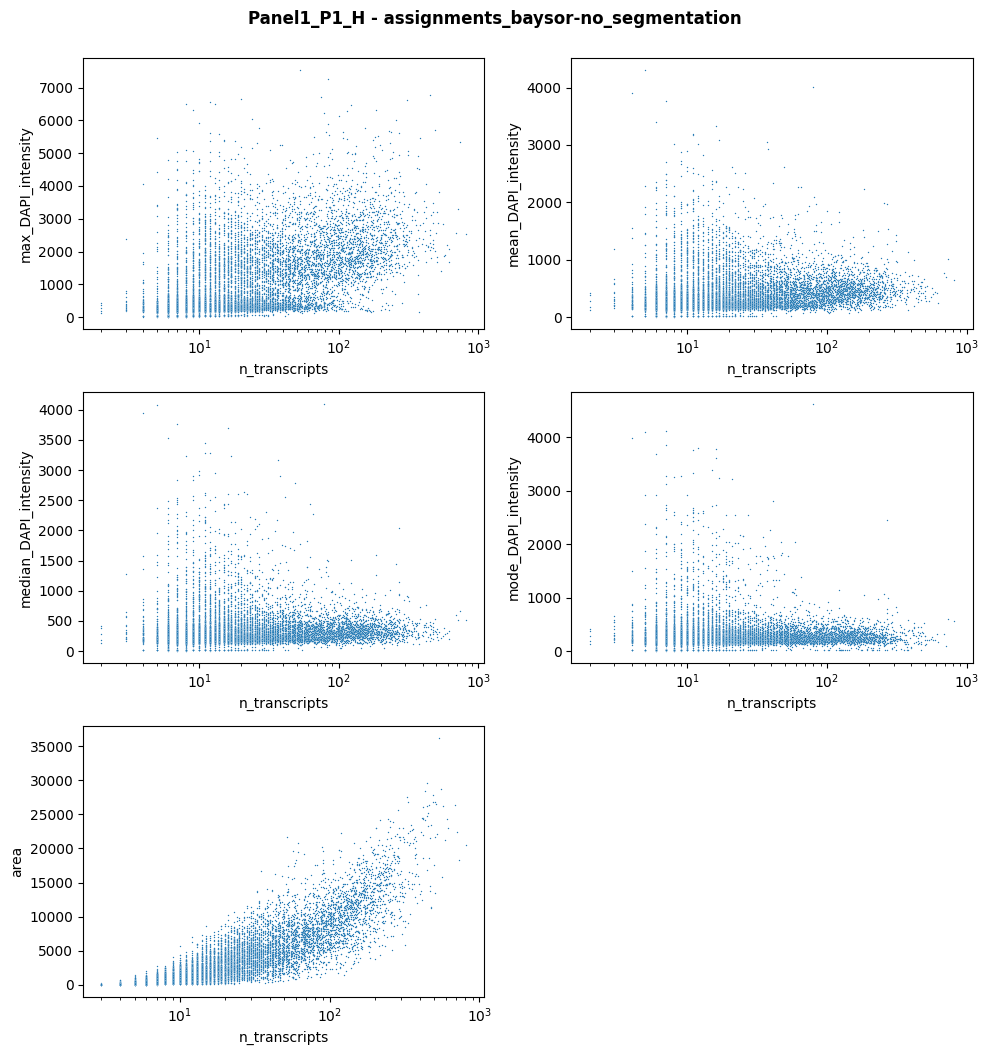

In [7]:
qc_cols=['max_DAPI_intensity','mean_DAPI_intensity','median_DAPI_intensity','mode_DAPI_intensity','area']

ncols=2
nrows=math.ceil(len(qc_cols)/ncols)
fig=plt.figure(figsize=(ncols*5,nrows*3.5))

fig_suptitle=' - '.join([panel_sample_name,bays_model_name])
fig.suptitle(fig_suptitle,fontweight='bold',y=1)

for n,qc_col in enumerate(qc_cols):
    ax=fig.add_subplot(nrows,ncols,n+1)
    sns.scatterplot(data=adata.obs,x='n_transcripts',y=qc_col,ax=ax,s=1)
    ax.set_xscale('log')

plt.tight_layout()

In [8]:
#'area','n_transcripts','avg_assignment_confidence','density','elongation','max_cluster_frac','lifespan'
print(adata)
adata_=adata[(adata.obs['n_transcripts']>25)\
            &(adata.obs['avg_assignment_confidence']>0.7)\
            &(adata.obs['max_cluster_frac']>0.5)\
            &(adata.obs['area']>500)\
            &(adata.obs['max_DAPI_intensity']>10**2)\
            ,:]
adata_            

AnnData object with n_obs × n_vars = 10447 × 541
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'mean_DAPI_intensity', 'median_DAPI_intensity', 'max_DAPI_intensity', 'mode_DAPI_intensity', 'cell_mask_area', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'pct_noise', 'raw_DAPI_intensities'
    layers: 'raw_counts'


View of AnnData object with n_obs × n_vars = 3805 × 541
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'mean_DAPI_intensity', 'median_DAPI_intensity', 'max_DAPI_intensity', 'mode_DAPI_intensity', 'cell_mask_area', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'pct_noise', 'raw_DAPI_intensities'
    layers: 'raw_counts'

Cell identity
False cell    8263
True cell     3805
Name: count, dtype: int64


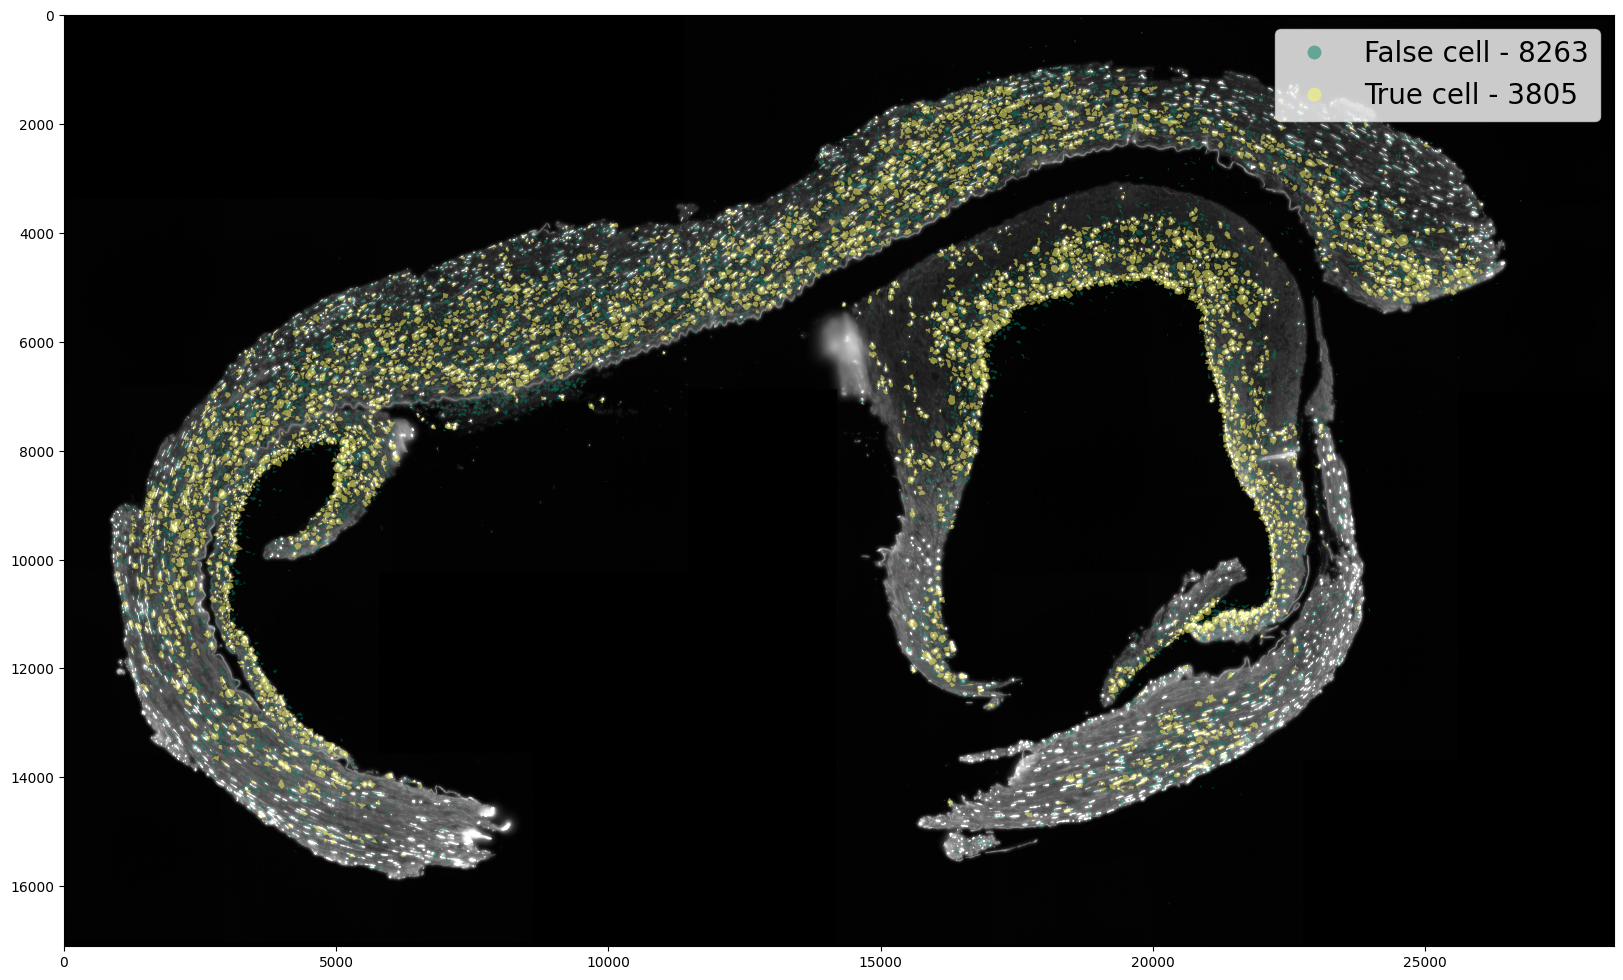

In [9]:
## Extract false nuclei that are below pixel intensity threshold
#false_nuclei=nucleus_polygon_pixel_metrics<int_thr
#false_nuclei=nucleus_polygon_pixel_metrics[metric_list]<int_thr


### CREATE GEOPANDAS DATAFRAMES OF FOR PLOTTING TRUE/FALSE NUCLEI
##  Extract pixel coordinates of nuclei polygons 
#nucleus_poly_coordinates=nucleus_bound.groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))
try:
    polygons_num_per_cell=(cell_bound.groupby('cell_id').apply(lambda x: len(x['vertex_x_pixel'])))
    cells_with_at_least_4_polygons=polygons_num_per_cell[polygons_num_per_cell>=4].index
    cell_poly_coordinates=cell_bound[cell_bound['cell_id'].isin(cells_with_at_least_4_polygons)].groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))
except ValueError:
    pass    

## Create GeoPandas dataframes containing pixel coordinates of nuclei polygons 
#nucleus_polygons=gpd.GeoDataFrame(index=nucleus_poly_coordinates.index,geometry=nucleus_poly_coordinates.values)
cell_polygons=gpd.GeoDataFrame(index=cell_poly_coordinates.index,geometry=cell_poly_coordinates.values)


## Add column indicating if cell is a true/false cell
cell_polygons['Cell identity']='True cell'
cell_polygons.loc[~cell_polygons.index.isin(adata_.obs.index),'Cell identity']='False cell'


#nucleus_polygons['Cell identity']='True cell'
#nucleus_polygons.loc[nucleus_polygons.index.isin(false_nuclei[false_nuclei].index),'Cell identity']='False cell'

print(cell_polygons['Cell identity'].value_counts())


## Plot cells with GeoPandas data indicating Cell identity (true/false) with colors overlaying
fig,ax=plt.subplots(1,1,figsize=(20,20))
orig_map=plt.cm.get_cmap('summer') 
reversed_map = orig_map#.reversed() 

## Add number of cells to the cell labels
conf_matrix=cell_polygons['Cell identity'].value_counts().sort_index()
leg_labels=[ind+ ' - ' +str(conf_matrix[ind]) for ind in conf_matrix.index]

cell_polygons.plot(ax=ax,column='Cell identity',cmap=reversed_map,legend=True,alpha=0.5,categorical=True,
                   legend_kwds={'fontsize':'20','labels':leg_labels})
#ax.set_facecolor('black')
ax.invert_yaxis()


## Plot original slide -> contrasted to the range of 0-0.98 quantile of pixel intesities 
#  -> whole slide appears brighter, as extreme intensive pixels get capped at 0.98 quantile 
orig_map=plt.cm.get_cmap('Greys') 
reversed_map = orig_map.reversed() 
img=ax.imshow((img_array),cmap=reversed_map,vmin=0, vmax=np.quantile(img_array,0.995))
#plt.colorbar(img, ax=ax)
plt.show()


In [10]:
import cv2
# Initialize an empty mask
mask = np.zeros(img_array.shape, dtype=np.uint8)
_10x_maskfn='/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/cell_segmentation/Panel1_P1_H/10x_nuclear_binary_mask.tif'
reader = OMETIFFReader(fpath=_10x_maskfn)
mask_10x,metadata,xml_metadata=reader.read()

for cell_id,cell_coord_df in cell_bound.groupby('cell_id'):
    
    if cell_id in adata_.obs.index:
        # Convert dataframe to a list of points
        points=cell_coord_df[['vertex_x_pixel','vertex_y_pixel']].values.astype(int)

        # Draw filled polygon on the mask
        cv2.fillPoly(mask, [points], color=1)
        

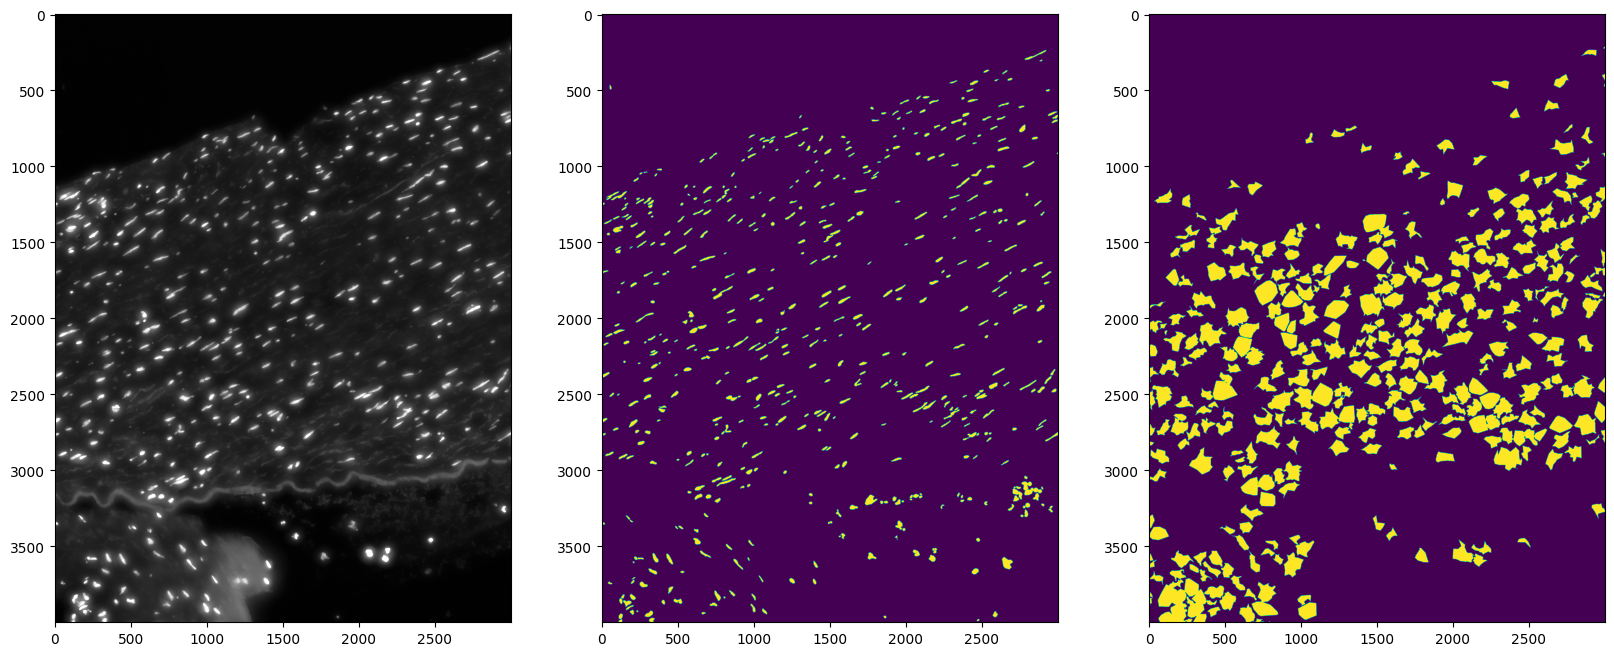

In [11]:
fig,ax=plt.subplots(1,3,figsize=(20,20))
ax[0].imshow((img_array[4000:8000,5000:8000]),cmap=reversed_map,vmin=0, vmax=np.quantile(img_array,0.998))
ax[1].imshow((mask_10x[4000:8000,5000:8000]))
ax[2].imshow((mask[4000:8000,5000:8000]))

In [12]:
asdfafd

NameError: name 'asdfafd' is not defined

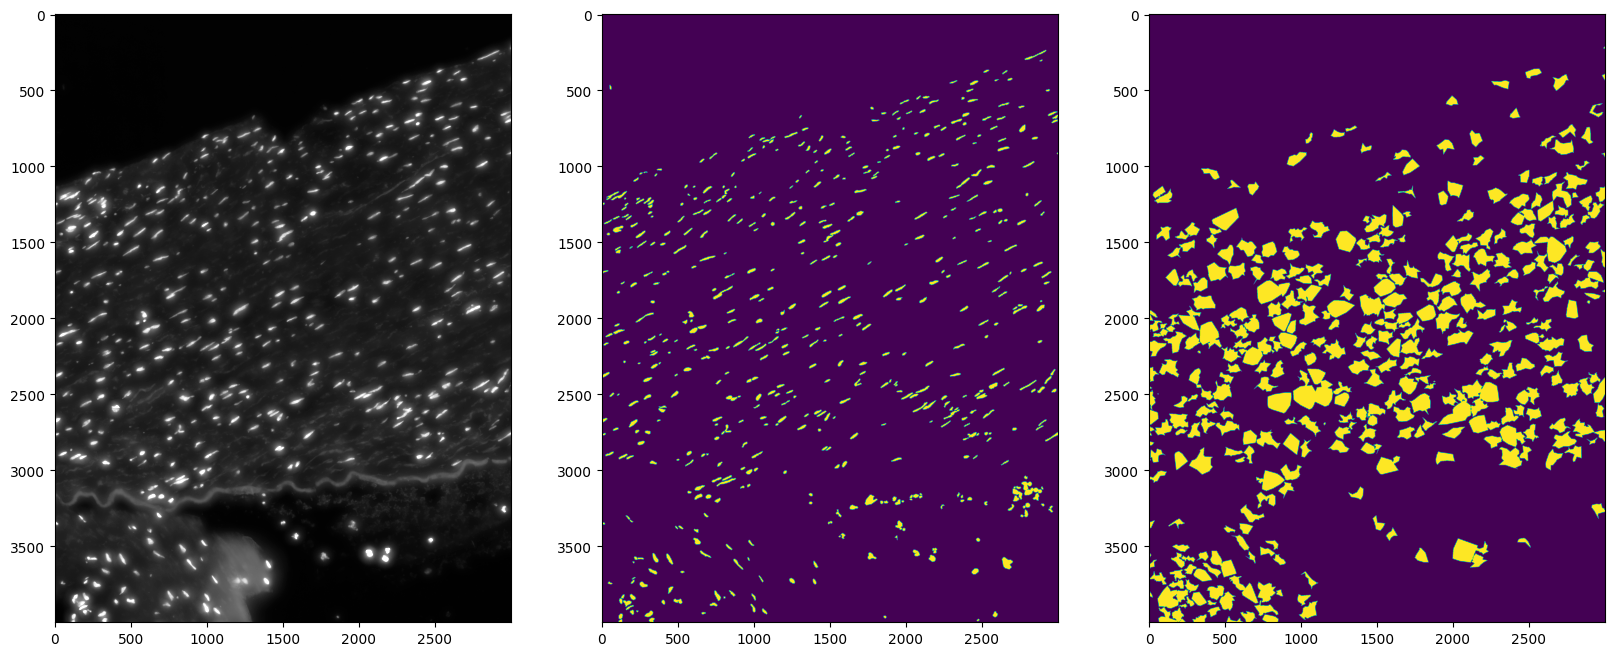

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,20))
ax[0].imshow((img_array[4000:8000,5000:8000]),cmap=reversed_map,vmin=0, vmax=np.quantile(img_array,0.998))
ax[1].imshow((mask_10x[4000:8000,5000:8000]))
ax[2].imshow((mask[4000:8000,5000:8000]))